In [ ]:
import numpy as np
from sympy import *

Airbag deployed at t = 0.0214s with speed = 51.09 m/s


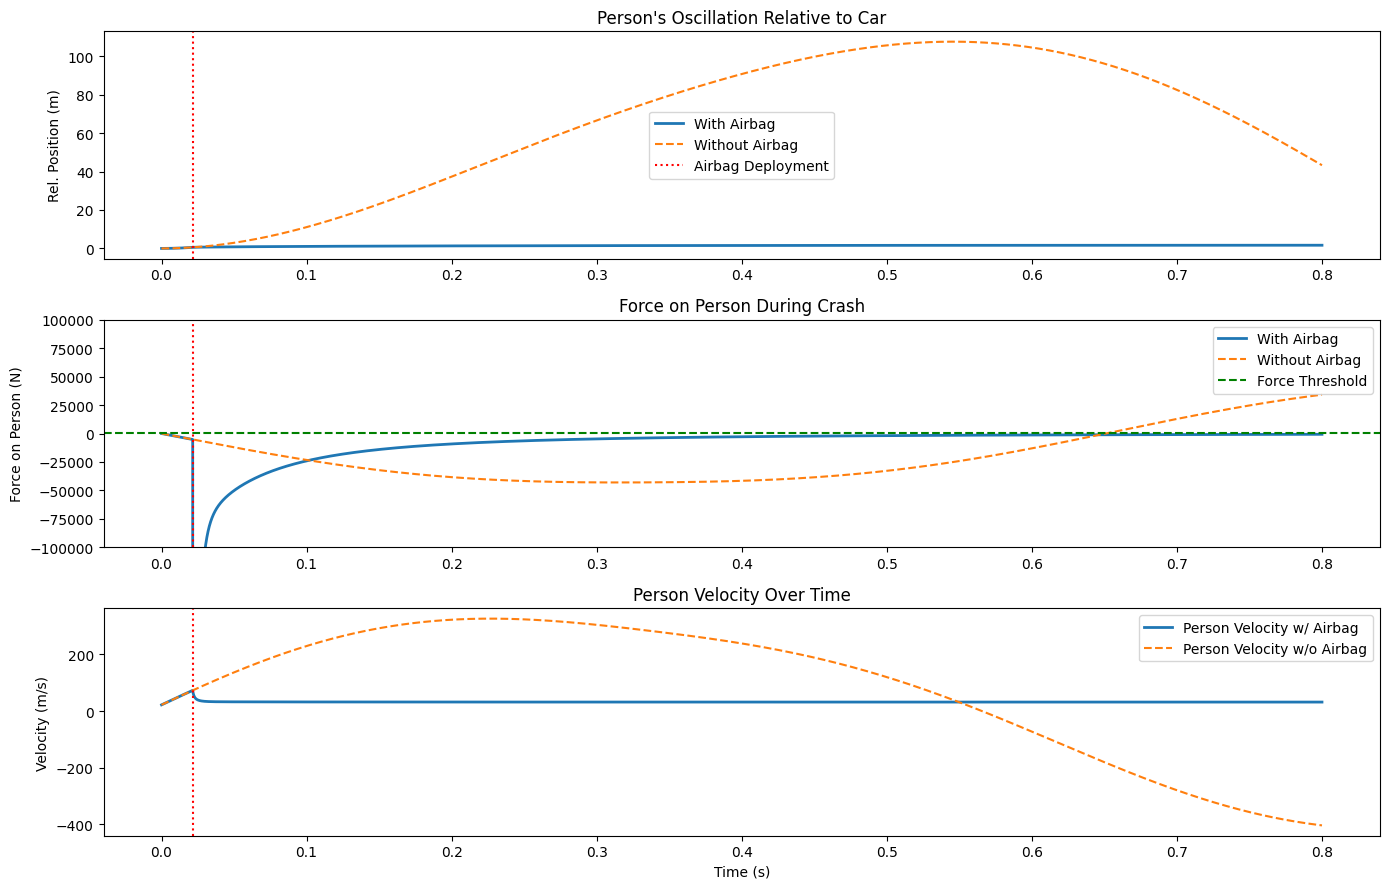

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# User-defined parameters
v_0_car = 22  # m/s (initial velocity of the car)
v_0_truck = 32.0  # m/s (initial velocity of the truck)
m_c = 1000.0  # kg (mass of the car)
m_t = 6000.0  # kg (mass of the truck)
m_p = 70.0     # kg (mass of the person)
force_threshold = m_p * 5  # N, shows the 10-12mph speed that is required for the airbags to pop FOR UNBELTED DRIVERS
seat_distance = 0.0025  # meters (distance between the car seat and person)
k_crumple_zone = 1200
k_airbag = force_threshold / 1.5  # N/m (spring constant)
recommended_deploy_velocity = 5  # m/s (velocity at which airbag deploys)

# Time settings
dt = 0.0000187
T_max = 0.8
time = np.arange(0, T_max, dt)
num_steps = len(time)

# Arrays for simulation
x_t = np.zeros(num_steps)
x_c = np.zeros(num_steps)
v_c = np.zeros(num_steps)
x_p = np.zeros(num_steps)
v_p = np.zeros(num_steps)
F_person = np.zeros(num_steps)
F_truck = np.zeros(num_steps)

# Initial conditions
x_t[0] = 0.0
x_c[0] = 0.0
v_c[0] = v_0_car
x_p[0] = -seat_distance
v_p[0] = v_0_car
v_t = v_0_truck  # truck velocity is constant

# Define the base damping coefficient (c_base) before airbag deployment
c_base = 100  # N·s/m (baseline damping coefficient)

# Airbag deployment control
deploy_time = None
trigger_time = None
deploy_delay = 0.02  # Delay after force exceeds threshold (20 ms)

# Airbag damping function with velocity dependence
def dynamic_damping(t, deploy_time, v_rel):
    if deploy_time is not None and t >= deploy_time:
        # Apply damping only when airbag is deployed, based on relative velocity
        return 3000 + 1000.0 * np.abs(v_rel)  # Increased damping with speed
    return c_base  # Base damping before airbag deploys

# Velocity-dependent damping for the Truck-Car interaction
# Materials like foam, metal folds, or reactive airbags might behave nonlinearly with speed.
def truck_car_damping(v_rel):
    base_damping = 2000.0  # Ns/m, baseline for low-speed impacts
    damping_slope = 1500.0  # Ns²/m², how much extra damping per m/s of relative velocity

    return base_damping + damping_slope * np.abs(v_rel)


# Equations of motion
def derivatives(x_c, v_c, x_p, v_p, t, deploy_time, v_t, x_t_current):
    # Compute the relative displacement and velocity between car and truck
    v_rel_truck = v_c - v_t  # relative velocity between car and truck
    x_rel_truck = x_c - x_t_current  # relative displacement using current truck position
    c_crash = truck_car_damping(v_rel_truck)
    F_truck_force = k_crumple_zone * x_t_current + c_crash * v_rel_truck # Truck impact force

    #car-person system:
    v_rel = v_p - v_c  # relative velocity between person and car
    rel_x = x_p - x_c
    c_airbag = dynamic_damping(t, deploy_time, v_rel)  # Apply dynamic damping
    F_spring = k_airbag * rel_x
    F_damper = c_airbag * v_rel
    F_total = F_spring + F_damper

    F_total = float(F_total)
    F_truck_force = float(F_truck_force)

    # Total force includes both the seatbelt system forces and the truck force
    F_total += F_truck_force
    # Car is pushed by the truck and pushed back by the person Person is only pushed by car (via seatbelt/airbag)
    a_c = (-F_truck_force + F_total) / m_c
    a_p = -F_total / m_p
    return np.array([v_c, a_c, v_p, a_p]), F_total, F_truck_force

# Runge-Kutta 4 Integration with delayed airbag deployment and truck impact
for i in range(num_steps - 1):
    t = time[i]
    y = np.array([x_c[i], v_c[i], x_p[i], v_p[i]])

    #k1, f1, f1_truck = derivatives(*y, t, deploy_time, v_t)
    k1, f1, f1_truck = derivatives(x_c[i], v_c[i], x_p[i], v_p[i], t, deploy_time, v_t, x_t[i])
    k2, _, _ = derivatives(*(y + 0.5 * dt * k1), t + 0.5 * dt, deploy_time, v_t, x_t[i])
    k3, _, _ = derivatives(*(y + 0.5 * dt * k2), t + 0.5 * dt, deploy_time, v_t, x_t[i])
    k4, _, _ = derivatives(*(y + dt * k3), t + dt, deploy_time, v_t, x_t[i])

    y_next = y + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
    x_c[i+1], v_c[i+1], x_p[i+1], v_p[i+1] = y_next

    rel_x = x_p[i+1] - x_c[i+1]
    v_rel = v_p[i+1] - v_c[i+1]
    F_person[i+1] = -k_airbag * rel_x - dynamic_damping(t, deploy_time, v_rel) * v_rel
    F_truck[i+1] = f1_truck

    # Step 1: note when force exceeds threshold
    if trigger_time is None and abs(F_person[i+1]) >= force_threshold:
        trigger_time = t

    # Step 2: deploy airbag after a delay when relative velocity exceeds threshold
    if trigger_time is not None and deploy_time is None:
        if t >= trigger_time + deploy_delay and np.abs(v_rel) >= recommended_deploy_velocity:
            deploy_time = t
            print(f"Airbag deployed at t = {deploy_time:.4f}s with speed = {abs(v_rel):.2f} m/s")

# No-airbag comparison (same as previous)
x_c_no = np.zeros(num_steps)
v_c_no = np.zeros(num_steps)
x_p_no = np.zeros(num_steps)
v_p_no = np.zeros(num_steps)
F_person_no = np.zeros(num_steps)
F_truck_no = np.zeros(num_steps)

x_c_no[0] = 0.0
v_c_no[0] = v_0_car
x_p_no[0] = -seat_distance
v_p_no[0] = v_0_car

for i in range(num_steps - 1):
    t = time[i]
    y = np.array([x_c_no[i], v_c_no[i], x_p_no[i], v_p_no[i]])

    k1, _, _ = derivatives(*y, t, None, v_t, x_t[i])
    k2, _, _ = derivatives(*(y + 0.5 * dt * k1), t + 0.5 * dt, None, v_t, x_t[i])
    k3, _, _ = derivatives(*(y + 0.5 * dt * k2), t + 0.5 * dt, None, v_t, x_t[i])
    k4, _, _ = derivatives(*(y + dt * k3), t + dt, None, v_t, x_t[i])

    y_next = y + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
    x_c_no[i+1], v_c_no[i+1], x_p_no[i+1], v_p_no[i+1] = y_next

    rel_x = x_p_no[i+1] - x_c_no[i+1]
    v_rel = v_p_no[i+1] - v_c_no[i+1]
    F_person_no[i+1] = -k_airbag * rel_x - c_base * v_rel
    F_truck_no[i+1] = m_t * (v_c_no[i+1] - v_t) / m_c

# Plotting
plt.figure(figsize=(14, 9))

# First subplot - Person's Oscillation Relative to Car
plt.subplot(3, 1, 1)
plt.plot(time, x_p - x_c, label="With Airbag", linewidth=2)
plt.plot(time, x_p_no - x_c_no, label="Without Airbag", linestyle='--')
if deploy_time:
    plt.axvline(deploy_time, color='r', linestyle=':', label='Airbag Deployment')
plt.ylabel("Rel. Position (m)")
plt.title("Person's Oscillation Relative to Car")
plt.legend()

# Second subplot - Force on Person During Crash (Zoomed in)
plt.subplot(3, 1, 2)
plt.plot(time, F_person, label="With Airbag", linewidth=2)
plt.plot(time, F_person_no, label="Without Airbag", linestyle='--')
plt.axhline(force_threshold, color='green', linestyle='--', label='Force Threshold')
if deploy_time:
    plt.axvline(deploy_time, color='r', linestyle=':')
plt.ylabel("Force on Person (N)")
plt.title("Force on Person During Crash")
plt.legend()
plt.ylim(-100000,100000)



# Third subplot - Person Velocity Over Time
plt.subplot(3, 1, 3)
plt.plot(time, v_p, label="Person Velocity w/ Airbag", linewidth=2)
plt.plot(time, v_p_no, label="Person Velocity w/o Airbag", linestyle='--')
if deploy_time:
    plt.axvline(deploy_time, color='r', linestyle=':')
plt.ylabel("Velocity (m/s)")
plt.xlabel("Time (s)")
plt.title("Person Velocity Over Time")
plt.legend()

plt.tight_layout()
plt.show()


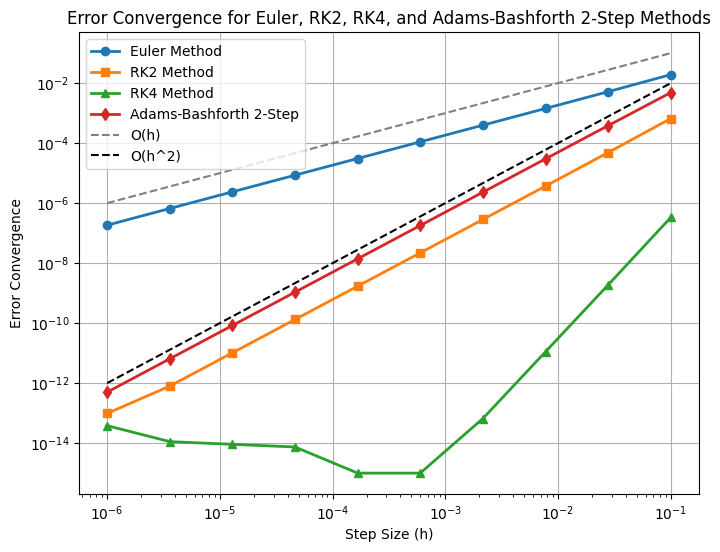

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define the true solution for comparison (simple example)
def true_solution(t):
    return np.exp(-t)

# Define the ODE (dy/dt = -y)
def f(t, y):
    return -y

# Euler Method
def euler_method(f, y0, t0, tf, h):
    t_values = np.arange(t0, tf, h)
    y_values = np.zeros(len(t_values))
    y_values[0] = y0
    for i in range(1, len(t_values)):
        y_values[i] = y_values[i-1] + h * f(t_values[i-1], y_values[i-1])
    return t_values, y_values

# Runge-Kutta 2nd Order (RK2)
def rk2_method(f, y0, t0, tf, h):
    t_values = np.arange(t0, tf, h)
    y_values = np.zeros(len(t_values))
    y_values[0] = y0
    for i in range(1, len(t_values)):
        k1 = f(t_values[i-1], y_values[i-1])
        k2 = f(t_values[i-1] + h/2, y_values[i-1] + h*k1/2)
        y_values[i] = y_values[i-1] + h * k2
    return t_values, y_values

# Runge-Kutta 4th Order (RK4)
def rk4_method(f, y0, t0, tf, h):
    t_values = np.arange(t0, tf, h)
    y_values = np.zeros(len(t_values))
    y_values[0] = y0
    for i in range(1, len(t_values)):
        k1 = f(t_values[i-1], y_values[i-1])
        k2 = f(t_values[i-1] + h/2, y_values[i-1] + h*k1/2)
        k3 = f(t_values[i-1] + h/2, y_values[i-1] + h*k2/2)
        k4 = f(t_values[i-1] + h, y_values[i-1] + h*k3)
        y_values[i] = y_values[i-1] + h/6 * (k1 + 2*k2 + 2*k3 + k4)
    return t_values, y_values

# Adams-Bashforth 2-Step (AB2)
def adams_bashforth_2(f, y0, t0, tf, h):
    t_values = np.arange(t0, tf, h)
    y_values = np.zeros(len(t_values))
    y_values[0] = y0
    # Use Euler's method for the first step
    y_values[1] = y_values[0] + h * f(t_values[0], y_values[0])
    for i in range(1, len(t_values)-1):
        y_values[i+1] = y_values[i] + h/2 * (3*f(t_values[i], y_values[i]) - f(t_values[i-1], y_values[i-1]))
    return t_values, y_values

# Define logarithmically spaced step sizes from 1e-5 to 1e-1
h_values = np.logspace(-6, -1, num=10)  # 10 values between 10^-5 and 10^-1

# Initial conditions
y0 = 1.0
t0 = 0.0
tf = 2.0

# Store errors for each method
errors_euler = []
errors_rk2 = []
errors_rk4 = []
errors_ab2 = []

for h in h_values:
    # Euler Method
    t_euler, y_euler = euler_method(f, y0, t0, tf, h)
    y_true = true_solution(t_euler)
    errors_euler.append(np.max(np.abs(y_true - y_euler)))

    # RK2 Method
    t_rk2, y_rk2 = rk2_method(f, y0, t0, tf, h)
    y_true = true_solution(t_rk2)
    errors_rk2.append(np.max(np.abs(y_true - y_rk2)))

    # RK4 Method
    t_rk4, y_rk4 = rk4_method(f, y0, t0, tf, h)
    y_true = true_solution(t_rk4)
    errors_rk4.append(np.max(np.abs(y_true - y_rk4)))

    # Adams-Bashforth 2-Step Method
    t_ab2, y_ab2 = adams_bashforth_2(f, y0, t0, tf, h)
    y_true = true_solution(t_ab2)
    errors_ab2.append(np.max(np.abs(y_true - y_ab2)))

# Plotting the error convergence
plt.figure(figsize=(8, 6))

plt.loglog(h_values, errors_euler, 'o-', label='Euler Method', linewidth=2)
plt.loglog(h_values, errors_rk2, 's-', label='RK2 Method', linewidth=2)
plt.loglog(h_values, errors_rk4, '^-', label='RK4 Method', linewidth=2)
plt.loglog(h_values, errors_ab2, 'd-', label='Adams-Bashforth 2-Step', linewidth=2)

# Reference lines for O(h) and O(h^2)
plt.loglog(h_values, h_values, '--', label='O(h)', color='gray')
plt.loglog(h_values, h_values**2, '--', label='O(h^2)', color='black')

plt.xlabel('Step Size (h)')
plt.ylabel('Error Convergence')
plt.title('Error Convergence for Euler, RK2, RK4, and Adams-Bashforth 2-Step Methods')
plt.legend()
plt.grid(True)
plt.show()


<ipython-input-5-f65ba070226e>:53: RuntimeWarning: overflow encountered in scalar multiply
  F_damper = -c * v_rel
<ipython-input-5-f65ba070226e>:74: RuntimeWarning: invalid value encountered in add
  k2, _ = derivatives(*(y_current + 0.5 * dt * k1), t + 0.5 * dt, deploy_time)
<ipython-input-5-f65ba070226e>:54: RuntimeWarning: invalid value encountered in scalar add
  F_total = F_spring + F_damper
<ipython-input-5-f65ba070226e>:78: RuntimeWarning: invalid value encountered in add
  y_next = y_current + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)


✅ Suggested optimal time step: Δt ≈ 1.00e-05 (error ≤ 1e-3)


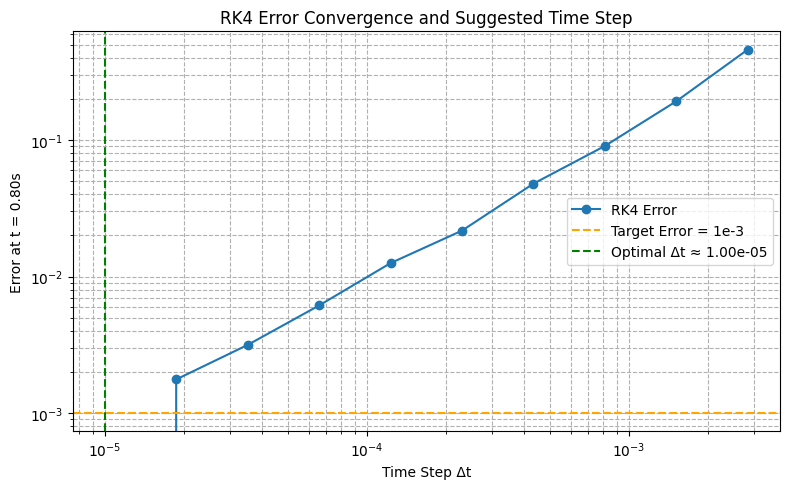

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# User-defined parameters
v_0_car = 50.0  # m/s
v_0_truck = 72.0  # m/s
m_c = 1700.0  # kg
m_t = 8000.0  # kg
m_p = 70.0     # kg
c_base = 300.0 # Base damping coefficient
force_threshold = m_c * 5  # N, shows the 10-12mph speed that is required for the airbags to pop FOR UNBELTED DRIVERS
seat_distance = 0.5  # meters
k = force_threshold / 1.5 # N/m
recommended_deploy_velocity = 5  # m/s (velocity at which airbag deploys)

# Time settings
dt = 0.0000187
T_max = 0.8
time = np.arange(0, T_max, dt)
num_steps = len(time)

# Arrays for simulation
x_c = np.zeros(num_steps)
v_c = np.zeros(num_steps)
x_p = np.zeros(num_steps)
v_p = np.zeros(num_steps)
F_person = np.zeros(num_steps)

# Initial conditions
x_c[0] = 0.0
v_c[0] = v_0_car
x_p[0] = -seat_distance
v_p[0] = 0.0

# Airbag deployment control
deploy_time = None
trigger_time = None
deploy_delay = 0.02  # Delay after force exceeds threshold (20 ms)

# Airbag damping function with velocity dependence
def dynamic_damping(t, deploy_time, v_rel):
    if deploy_time is not None and t >= deploy_time:
        # Apply damping only when airbag is deployed, based on relative velocity
        return 3000.0 + 1000.0 * np.abs(v_rel)  # Increased damping with speed
    return c_base  # Base damping before airbag deploys

# Equations of motion
def derivatives(x_c, v_c, x_p, v_p, t, deploy_time):
    v_rel = v_p - v_c  # relative velocity
    rel_x = x_p - x_c
    c = dynamic_damping(t, deploy_time, v_rel)  # Apply dynamic damping
    F_spring = -k * rel_x
    F_damper = -c * v_rel
    F_total = F_spring + F_damper
    a_c = -F_total / m_c
    a_p = F_total / m_p
    return np.array([v_c, a_c, v_p, a_p]), F_total

# Runge-Kutta 4 Integration with delayed airbag deployment
def rk4_integrator(y0, dt, T, deploy_delay=0.02):
    num_steps = int(T / dt)
    y = np.zeros((num_steps, len(y0)))
    y[0] = y0
    F_person = np.zeros(num_steps)
    deploy_time = None
    trigger_time = None
    time = np.arange(0, T, dt)

    for i in range(num_steps - 1):
        t = time[i]
        y_current = y[i]

        k1, _ = derivatives(*y_current, t, deploy_time)
        k2, _ = derivatives(*(y_current + 0.5 * dt * k1), t + 0.5 * dt, deploy_time)
        k3, _ = derivatives(*(y_current + 0.5 * dt * k2), t + 0.5 * dt, deploy_time)
        k4, _ = derivatives(*(y_current + dt * k3), t + dt, deploy_time)

        y_next = y_current + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
        y[i+1] = y_next

        # Calculate force on the person
        rel_x = y_next[2] - y_next[0]
        v_rel = y_next[3] - y_next[1]
        F_person[i+1] = -k * rel_x - dynamic_damping(t, deploy_time, v_rel) * v_rel

        # Airbag deployment logic
        if trigger_time is None and abs(F_person[i+1]) >= force_threshold:
            trigger_time = t
        if trigger_time is not None and deploy_time is None:
            if t >= trigger_time + deploy_delay and np.abs(v_rel) >= recommended_deploy_velocity:
                deploy_time = t

    return y, F_person, deploy_time

# Reference solution with a very small time step for high accuracy
dt_ref = 1e-5
y0 = [0.0, v_0_car, -seat_distance, 0.0]
ref_solution, _, _ = rk4_integrator(y0, dt_ref, T_max)

# Time steps to test
dt_values = np.logspace(-5, -2, 12)
errors = []
dt_optimal = None

# Calculate errors for different time steps
for dt in dt_values:
    sol, _, _ = rk4_integrator(y0, dt, T_max)
    error = np.linalg.norm(sol[-1] - ref_solution[-1])  # Compare final positions
    errors.append(error)

    if error <= 1e-3:  # Desired accuracy threshold
        dt_optimal = dt  # keep updating to get the largest one below threshold

# Plotting error convergence
plt.figure(figsize=(8, 5))
plt.loglog(dt_values, errors, 'o-', label='RK4 Error')
plt.axhline(1e-3, color='orange', linestyle='--', label=f'Target Error = 1e-3')
if dt_optimal:
    plt.axvline(dt_optimal, color='green', linestyle='--', label=f'Optimal Δt ≈ {dt_optimal:.2e}')
    print(f"✅ Suggested optimal time step: Δt ≈ {dt_optimal:.2e} (error ≤ 1e-3)")
else:
    print("⚠️ No time step met the error tolerance. Try increasing the tolerance or refining dt range.")

plt.xlabel("Time Step Δt")
plt.ylabel("Error at t = {:.2f}s".format(T_max))
plt.title("RK4 Error Convergence and Suggested Time Step")
plt.grid(True, which="both", ls="--")
plt.legend()
plt.tight_layout()
plt.show()


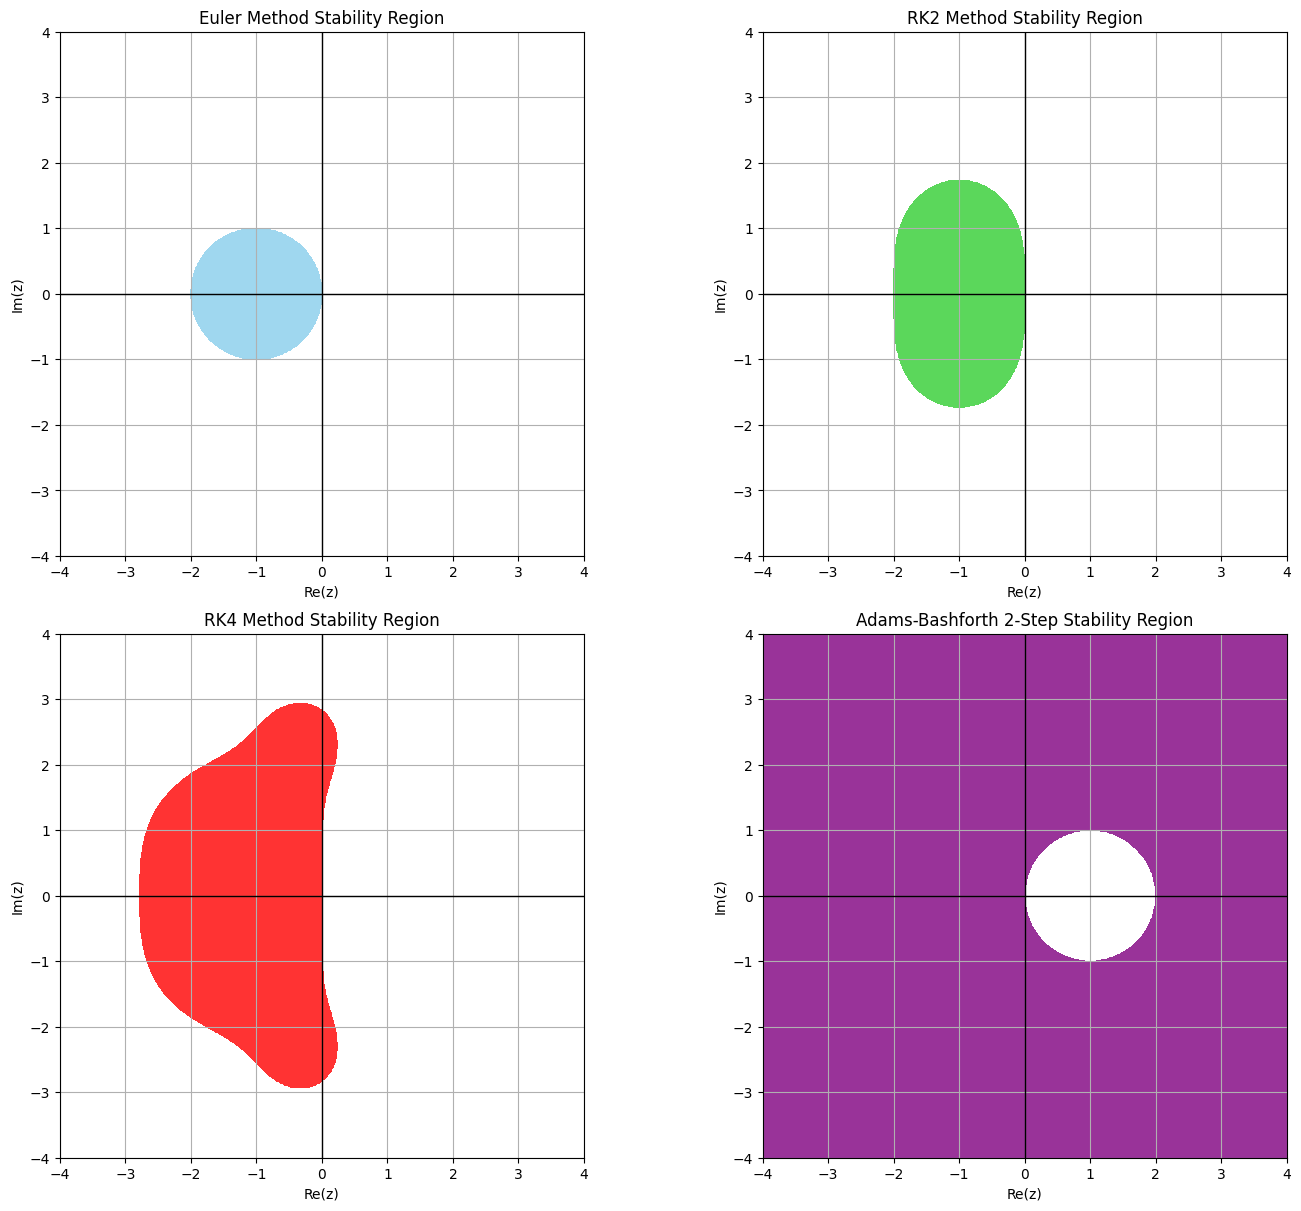

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Complex grid
x = np.linspace(-4, 4, 800)
y = np.linspace(-4, 4, 800)
X, Y = np.meshgrid(x, y)
Z = X + 1j * Y

# Stability functions
def euler(z):
    return np.abs(1 + z)

def rk2(z):
    return np.abs(1 + z + 0.5 * z**2)

def rk4(z):
    return np.abs(1 + z + z**2 / 2 + z**3 / 6 + z**4 / 24)

# For Adams-Bashforth 2-Step
def ab2(z):
    # Amplification factor R(z) = 1 + z * (3/2) - z * (1/2) * e^{-z} ≈ (1 + 0.5*z)/(1 - 1.5*z)
    # Using this approximation for visualization purposes
    return np.abs((1 + 0.5 * z) / (1 - 1.5 * z))

# Create stability masks
stability_euler = euler(Z) <= 1
stability_rk2 = rk2(Z) <= 1
stability_rk4 = rk4(Z) <= 1
stability_ab2 = ab2(Z) <= 1

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(14, 12), constrained_layout=True)

# Euler
axs[0, 0].contourf(X, Y, stability_euler, levels=[0.5, 1], colors=['skyblue'], alpha=0.8)
axs[0, 0].set_title("Euler Method Stability Region")
axs[0, 0].axhline(0, color='black', lw=1)
axs[0, 0].axvline(0, color='black', lw=1)
axs[0, 0].set_xlabel("Re(z)")
axs[0, 0].set_ylabel("Im(z)")
axs[0, 0].set_aspect('equal')
axs[0, 0].grid(True)

# RK2
axs[0, 1].contourf(X, Y, stability_rk2, levels=[0.5, 1], colors=['limegreen'], alpha=0.8)
axs[0, 1].set_title("RK2 Method Stability Region")
axs[0, 1].axhline(0, color='black', lw=1)
axs[0, 1].axvline(0, color='black', lw=1)
axs[0, 1].set_xlabel("Re(z)")
axs[0, 1].set_ylabel("Im(z)")
axs[0, 1].set_aspect('equal')
axs[0, 1].grid(True)

# RK4
axs[1, 0].contourf(X, Y, stability_rk4, levels=[0.5, 1], colors=['red'], alpha=0.8)
axs[1, 0].set_title("RK4 Method Stability Region")
axs[1, 0].axhline(0, color='black', lw=1)
axs[1, 0].axvline(0, color='black', lw=1)
axs[1, 0].set_xlabel("Re(z)")
axs[1, 0].set_ylabel("Im(z)")
axs[1, 0].set_aspect('equal')
axs[1, 0].grid(True)

# Adams-Bashforth 2
axs[1, 1].contourf(X, Y, stability_ab2, levels=[0.5, 1], colors=['purple'], alpha=0.8)
axs[1, 1].set_title("Adams-Bashforth 2-Step Stability Region")
axs[1, 1].axhline(0, color='black', lw=1)
axs[1, 1].axvline(0, color='black', lw=1)
axs[1, 1].set_xlabel("Re(z)")
axs[1, 1].set_ylabel("Im(z)")
axs[1, 1].set_aspect('equal')
axs[1, 1].grid(True)

plt.show()


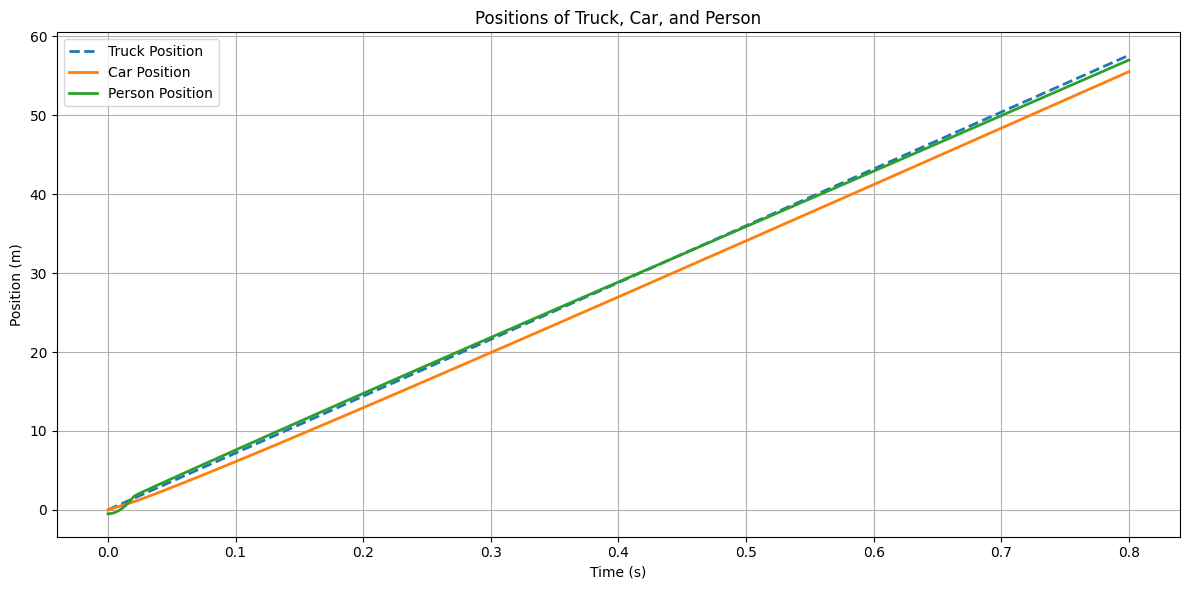

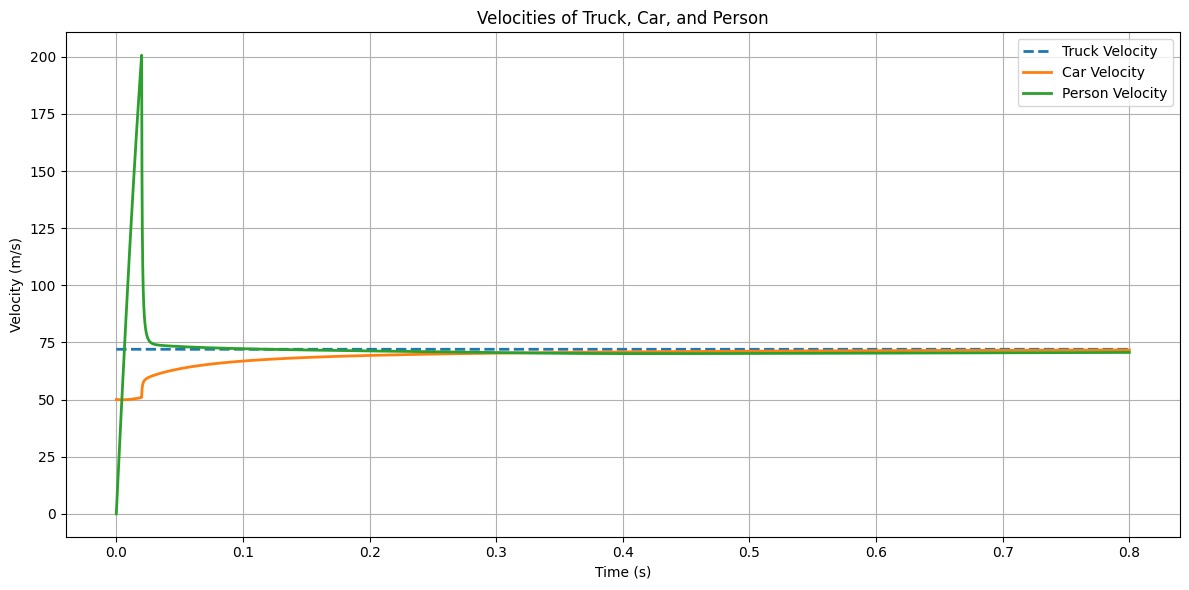

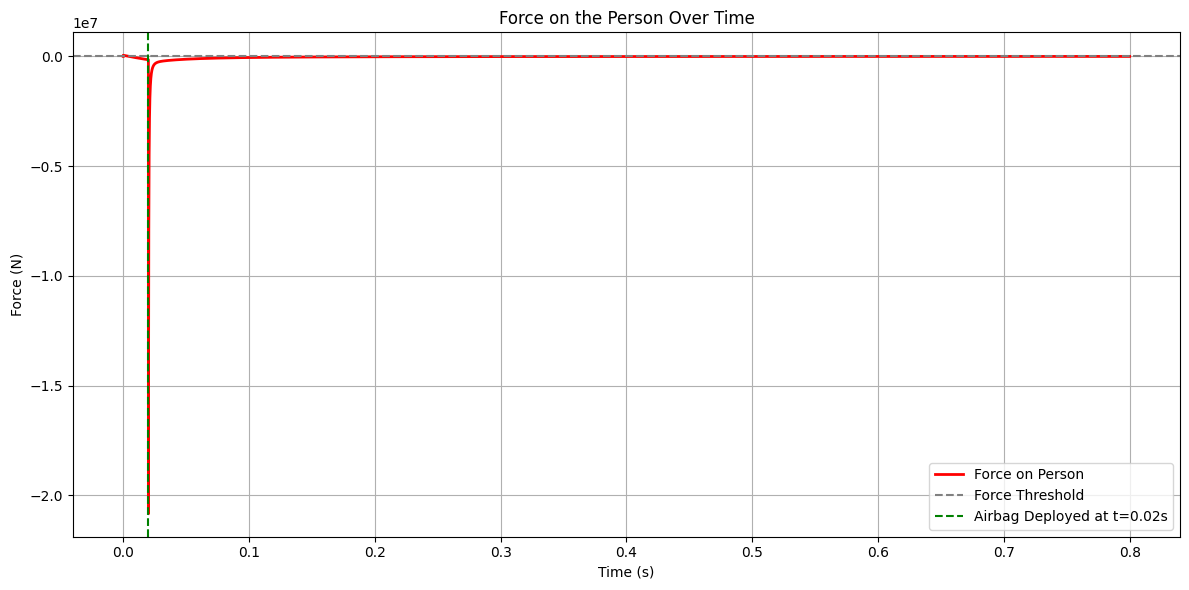

In [ ]:
# ... [all your code above remains the same up to the RK4 loop] ...

caught = False  # Flag for when truck and car latch together
shared_velocity = None  # Will hold shared velocity after inelastic collision

for i in range(num_steps - 1):
    t = time[i]
    y = np.array([x_c[i], v_c[i], x_p[i], v_p[i]])

    # Check if truck and car have matched velocity (inelastic collision happens)
    if not caught and np.abs(v_c[i] - v_t) < 0.01 and (x_c[i] - x_t[i]) > 0:  # they collide and match speed
        caught = True
        shared_velocity = (m_c * v_c[i] + m_t * v_t) / (m_c + m_t)  # momentum conservation
        print(f"Truck and car latch at t = {t:.4f}s with shared velocity = {shared_velocity:.2f} m/s")

    if caught:
        # From this point, car and truck move together at shared velocity
        v_c[i] = v_t = shared_velocity
        x_c[i+1] = x_c[i] + v_c[i] * dt
        x_t[i+1] = x_c[i+1]  # same position
        v_c[i+1] = v_t  # shared velocity

        # Only the person is still dynamic, simulate them inside the car
        v_rel = v_p[i] - v_c[i]
        rel_x = x_p[i] - x_c[i]
        c_airbag = dynamic_damping(t, deploy_time, v_rel)
        F_spring = k_airbag * rel_x
        F_damper = c_airbag * v_rel
        F_total = F_spring + F_damper
        a_p = -F_total / m_p

        v_p[i+1] = v_p[i] + a_p * dt
        x_p[i+1] = x_p[i] + v_p[i] * dt
        F_person[i+1] = -F_total
        F_truck[i+1] = 0  # no more truck force, they move together now

    else:
        # Standard RK4 integration before truck and car latch
        k1, f1, f1_truck = derivatives(x_c[i], v_c[i], x_p[i], v_p[i], t, deploy_time, v_t, x_t[i])
        k2, _, _ = derivatives(*(y + 0.5 * dt * k1), t + 0.5 * dt, deploy_time, v_t, x_t[i])
        k3, _, _ = derivatives(*(y + 0.5 * dt * k2), t + 0.5 * dt, deploy_time, v_t, x_t[i])
        k4, _, _ = derivatives(*(y + dt * k3), t + dt, deploy_time, v_t, x_t[i])

        y_next = y + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
        x_c[i+1], v_c[i+1], x_p[i+1], v_p[i+1] = y_next

        rel_x = x_p[i+1] - x_c[i+1]
        v_rel = v_p[i+1] - v_c[i+1]
        F_person[i+1] = -k_airbag * rel_x - dynamic_damping(t, deploy_time, v_rel) * v_rel
        F_truck[i+1] = f1_truck
        x_t[i+1] = x_t[i] + v_t * dt  # truck keeps moving

        # Step 1: note when force exceeds threshold
        if trigger_time is None and abs(F_person[i+1]) >= force_threshold:
            trigger_time = t

        # Step 2: deploy airbag after a delay when relative velocity exceeds threshold
        if trigger_time is not None and deploy_time is None:
            if t >= trigger_time + deploy_delay and np.abs(v_rel) >= recommended_deploy_velocity:
                deploy_time = t
                print(f"Airbag deployed at t = {deploy_time:.4f}s with speed = {abs(v_rel):.2f} m/s")
import matplotlib.pyplot as plt

# Plot positions
plt.figure(figsize=(12, 6))
plt.plot(time, x_t, label="Truck Position", linestyle="--", linewidth=2)
plt.plot(time, x_c, label="Car Position", linewidth=2)
plt.plot(time, x_p, label="Person Position", linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.title("Positions of Truck, Car, and Person")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot velocities
plt.figure(figsize=(12, 6))
plt.plot(time, np.full_like(time, v_t), label="Truck Velocity", linestyle="--", linewidth=2)
plt.plot(time, v_c, label="Car Velocity", linewidth=2)
plt.plot(time, v_p, label="Person Velocity", linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Velocities of Truck, Car, and Person")
plt.legend()
plt.grid(True)+
plt.tight_layout()
plt.show()

# Plot force on person
plt.figure(figsize=(12, 6))
plt.plot(time, F_person, label="Force on Person", color="red", linewidth=2)
plt.axhline(force_threshold, color="gray", linestyle="--", label="Force Threshold")
if deploy_time:
    plt.axvline(deploy_time, color="green", linestyle="--", label=f"Airbag Deployed at t={deploy_time:.2f}s")
plt.xlabel("Time (s)")
plt.ylabel("Force (N)")
plt.title("Force on the Person Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Code that implements the first order differential equations and applies it to RK4**


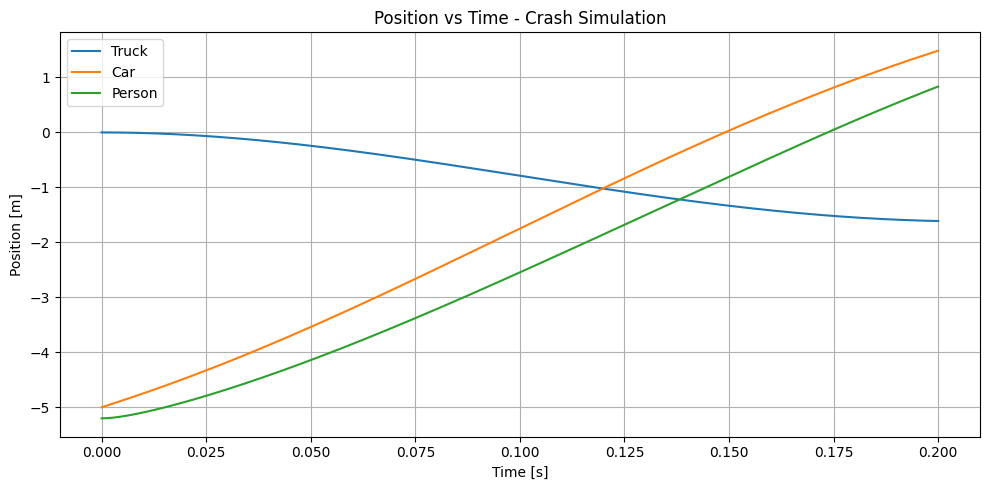

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 1. System Parameters (example values)
# -------------------------------
m_t = 1000   # truck mass [kg]
m_c = 800    # car mass [kg]
m_p = 70     # person mass [kg]

k_tc = 50000   # spring stiffness between truck and car [N/m]
b_tc = 1000    # damping coefficient between truck and car [Ns/m]

b_airbag = 500  # nonlinear damping coefficient of airbag [unit varies]
n = 2           # exponent for nonlinear airbag damping

# -------------------------------
# 2. Force Model / Derivative Function
# -------------------------------
def f(t, y):
    """
    Computes the derivative dy/dt of the state vector y at time t.
    State vector y contains [x_t, x_c, x_p, v_t, v_c, v_p]
    """
    # Unpack state vector
    x_t, x_c, x_p, v_t, v_c, v_p = y

    # Spring-damper force between truck and car
    F_tc = k_tc * (x_t - x_c) + b_tc * (v_t - v_c)

    # Nonlinear airbag force between car and person
    rel_vel_cp = v_c - v_p
    F_cp = b_airbag * abs(rel_vel_cp)**n * np.sign(rel_vel_cp)

    # Newton's Second Law (F = ma)
    a_t = -F_tc / m_t
    a_c = (F_tc - F_cp) / m_c
    a_p = F_cp / m_p

    # Return derivative of the state vector
    return np.array([v_t, v_c, v_p, a_t, a_c, a_p])

# -------------------------------
# 3. RK4 Step Function
# -------------------------------
def rk4_step(t, y, h, f):
    """
    Performs a single RK4 step from time t with state y using step size h.
    """
    k1 = f(t, y)
    k2 = f(t + h/2, y + h/2 * k1)
    k3 = f(t + h/2, y + h/2 * k2)
    k4 = f(t + h, y + h * k3)
    return y + (h/6) * (k1 + 2*k2 + 2*k3 + k4)

# -------------------------------
# 4. Initial Conditions
# -------------------------------
x_t0 = 0.0
x_c0 = -5.0
x_p0 = -5.2

v_t0 = 0.0
v_c0 = 25.0  # car moving toward stationary truck
v_p0 = 0.0

y0 = np.array([x_t0, x_c0, x_p0, v_t0, v_c0, v_p0])  # initial state
t0 = 0.0
T_final = 0.2   # simulate for 0.2 seconds
h = 0.0005      # time step [s]

# -------------------------------
# 5. Simulation Loop
# -------------------------------
t = t0
y = y0.copy()
trajectory = [y]
time_points = [t]

while t < T_final:
    y = rk4_step(t, y, h, f)
    t += h
    trajectory.append(y)
    time_points.append(t)

trajectory = np.array(trajectory)

# -------------------------------
# 6. Plotting Results
# -------------------------------
plt.figure(figsize=(10, 5))
plt.plot(time_points, trajectory[:, 0], label='Truck')
plt.plot(time_points, trajectory[:, 1], label='Car')
plt.plot(time_points, trajectory[:, 2], label='Person')
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.title('Position vs Time - Crash Simulation')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
